In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshanpdl","key":"66ce4e4bafff81eacd41b1f61f52c2a7"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

 99% 805M/812M [00:07<00:00, 173MB/s]
100% 812M/812M [00:07<00:00, 120MB/s]


In [ ]:
#8.6 Copying images to training, validation, and test directories
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname)

make_subset("train", start_index = 0, end_index = 1000)
make_subset("validation", start_index = 1000, end_index = 1500)
make_subset("test", start_index = 1500, end_index = 2500)

In [ ]:
# 8.9 - Using image_dataset_from_directory to read images
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

##Another Take on Pretrained CNNs (VGC16)

## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 33ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 14.4354 - accuracy: 0.9230 - val_loss: 3.5045 - val_accuracy: 0.9710
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 4.7178 - accuracy: 0.9660 - val_loss: 4.3385 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2.0754 - accuracy: 0.9850 - val_loss: 3.2608 - val_accuracy: 0.9670
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1525 - accuracy: 0.9890 - val_loss: 4.1641 - val_accuracy: 0.9840
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7340 - accuracy: 0.9925 - val_loss: 6.3123 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7310 - accuracy: 0.9930 - val_loss: 4.3006 - val_accuracy: 0.9800
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.5892 - accuracy: 0.9960 - val_loss: 4.4955 - val_accuracy: 0.9770
Epoch 8/20
63/63 [

**Plotting the results**

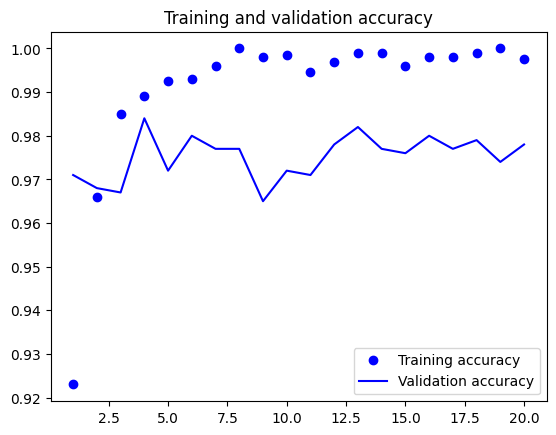

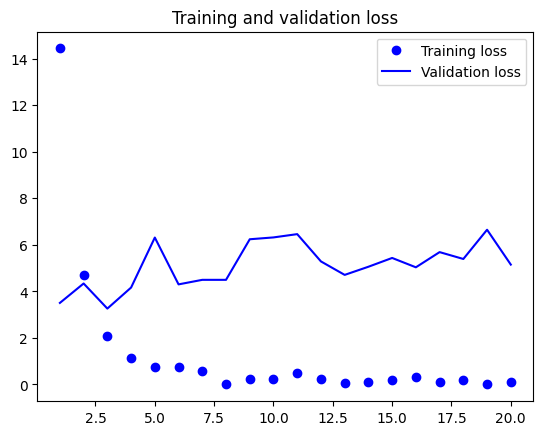

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 13s 181ms/step - loss: 16.5460 - accuracy: 0.8975 - val_loss: 12.8970 - val_accuracy: 0.9270
Epoch 2/50
63/63 [==============================] - 10s 147ms/step - loss: 9.4440 - accuracy: 0.9375 - val_loss: 3.8498 - val_accuracy: 0.9730
Epoch 3/50
63/63 [==============================] - 9s 145ms/step - loss: 5.9581 - accuracy: 0.9555 - val_loss: 4.7355 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 10s 151ms/step - loss: 5.2352 - accuracy: 0.9530 - val_loss: 4.3241 - val_accuracy: 0.9770
Epoch 5/50
63/63 [==============================] - 10s 148ms/step - loss: 4.2255 - accuracy: 0.9635 - val_loss: 17.2977 - val_accuracy: 0.9230
Epoch 6/50
63/63 [==============================] - 10s 150ms/step - loss: 3.6683 - accuracy: 0.9690 - val_loss: 6.1484 - val_accuracy: 0.9660
Epoch 7/50
63/63 [==============================] - 10s 155ms/step - loss: 3.9627 - accuracy: 0.9645 - val_loss: 3.4839 - val_accuracy: 0.97

**Plotting the results**



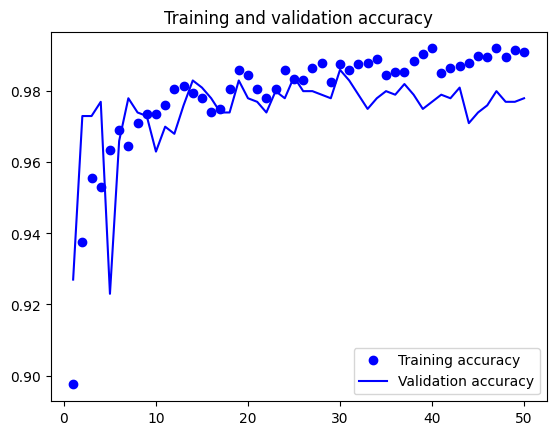

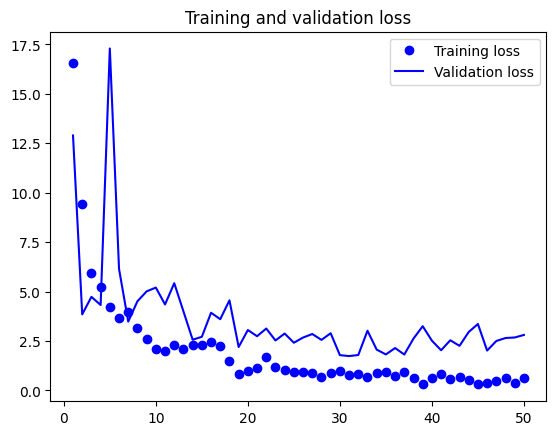

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 102ms/step - loss: 2.4583 - accuracy: 0.9745
Test accuracy: 0.975


**The final test accuracy with data augmentation is 97.45 %**

### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 189ms/step - loss: 0.3185 - accuracy: 0.9935 - val_loss: 2.7171 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 12s 180ms/step - loss: 0.7989 - accuracy: 0.9865 - val_loss: 2.5466 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - 12s 181ms/step - loss: 0.4825 - accuracy: 0.9885 - val_loss: 2.5721 - val_accuracy: 0.9760
Epoch 4/30
63/63 [==============================] - 12s 184ms/step - loss: 0.4920 - accuracy: 0.9925 - val_loss: 2.3831 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 11s 179ms/step - loss: 0.2310 - accuracy: 0.9925 - val_loss: 2.4380 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 11s 178ms/step - loss: 0.1809 - accuracy: 0.9955 - val_loss: 2.3895 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 11s 179ms/step - loss: 0.1912 - accuracy: 0.9925 - val_loss: 2.2679 - val_accuracy: 0.9810

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 100ms/step - loss: 1.6845 - accuracy: 0.9775
Test accuracy: 0.978


**The final test accuracy of the fine-tuned model is 97.8 % which is a 0.35 % improvement over the Part 1 model where the data was augmented, but the model was not fine-tuned**